##  MPI ping-pong measuring message latency and bandwidth

In [1]:
n = 2 # number of processes
from ipyparallel import Cluster
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"] = "1" # OpenMPI flag to oversubscribe in case we have less cpus than n
cluster = await Cluster(engines="mpi").start_and_connect(n=n, activate=True)

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

In [2]:
%%px
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if size != 2:
    if rank == 0:
        print("This program requires exactly 2 processes")
    exit()

partner_rank = 1 - rank
message_sizes = [1, 10, 100, 1000, 10000, int(1e5), int(1e6), int(1e7), int(1e8) ]  # bytes
niter = 1000

latencies = []
bandwidths = []

for size_bytes in message_sizes:
    # Create message
    msg = np.zeros(size_bytes, dtype='b')  # bytes array
    comm.Barrier()  # synchronize before timing
    start = MPI.Wtime()

    for _ in range(niter):
        if rank == 0:
            comm.Send([msg, MPI.BYTE], dest=partner_rank) # uppercase methods are used for buffer-like objects
            comm.Recv([msg, MPI.BYTE], source=partner_rank)
        else:
            comm.Recv([msg, MPI.BYTE], source=partner_rank)
            comm.Send([msg, MPI.BYTE], dest=partner_rank)

    end = MPI.Wtime()
    total_time = end - start
    avg_rtt = total_time / niter
    one_way_latency = avg_rtt / 2
    latencies.append(one_way_latency * 1e6)  # µs

    # Bandwidth = message size / one-way time
    bw = (size_bytes / one_way_latency) / 1e6  # MB/s
    bandwidths.append(bw)

    if rank == 0:
        print(f"Size: {size_bytes} B, latency: {one_way_latency*1e6:.2f} µs, bandwidth: {bw:.2f} MB/s")

[stdout:0] Size: 1 B, latency: 1.18 µs, bandwidth: 0.85 MB/s
Size: 10 B, latency: 1.27 µs, bandwidth: 7.85 MB/s
Size: 100 B, latency: 1.17 µs, bandwidth: 85.47 MB/s
Size: 1000 B, latency: 1.46 µs, bandwidth: 683.52 MB/s
Size: 10000 B, latency: 3.73 µs, bandwidth: 2683.29 MB/s
Size: 100000 B, latency: 13.01 µs, bandwidth: 7687.14 MB/s
Size: 1000000 B, latency: 103.72 µs, bandwidth: 9640.97 MB/s
Size: 10000000 B, latency: 1496.01 µs, bandwidth: 6684.47 MB/s
Size: 100000000 B, latency: 13441.05 µs, bandwidth: 7439.89 MB/s


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[output:0]

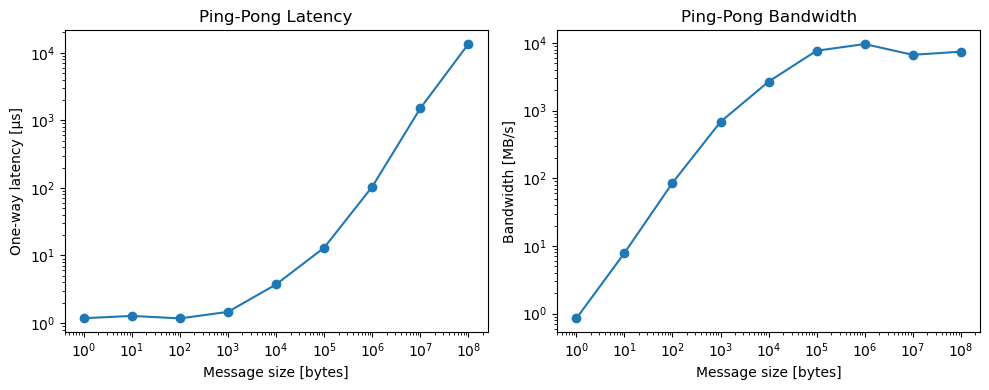

In [3]:
%%px
if rank == 0:
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.loglog(message_sizes, latencies, 'o-')
    plt.xlabel("Message size [bytes]")
    plt.ylabel("One-way latency [µs]")
    plt.title("Ping-Pong Latency")

    plt.subplot(1,2,2)
    plt.loglog(message_sizes, bandwidths, 'o-')
    plt.xlabel("Message size [bytes]")
    plt.ylabel("Bandwidth [MB/s]")
    plt.title("Ping-Pong Bandwidth")

    plt.tight_layout()
    plt.show()